# Example 5: Sum up displacement
This example describes how to correlate faults extracted at different time steps.

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [10]:
!git clone https://github.com/thilowrona/fault_analysis_toolbox

fatal: destination path 'fault_analysis_toolbox' already exists and is not an empty directory.


In [11]:
!pip3 install vtk
!pip3 install git+https://github.com/ulikoehler/cv_algorithms.git

  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-req-build-kjfzck88
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-req-build-kjfzck88
  Created wheel for cv-algorithms: filename=cv_algorithms-1.0.0-cp37-cp37m-linux_x86_64.whl size=43518 sha256=8c8be0b928804d569f03969afe6a5e1b24116c291c1b3f9f648a3b8859953e4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ahmwnf6_/wheels/0b/45/f6/dfa0d535f50a0148a4c7d6912942fdb7a6445d7196a2591cbe
Successfully built cv-algorithms


Now we can load the python packages:

In [12]:
import numpy as np 
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from sys import stdout

and the functions from the fault analysis toolbox that we want to use:

In [13]:
import sys
sys.path.append('/content/fault_analysis_toolbox/code/')

from image_processing import guo_hall
from edits import *
from metrics import *
from plots import *

## Load and plot faults

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [14]:
Gs = []
for n in range(3,50):
  Gs.append(pickle.load(open('/content/fault_analysis_toolbox/examples/5-displacement/graphs/g_'+ str(n) + '.p', 'rb')))

Now we can visualize these faults:

In [15]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_attribute(Gs[time], 'slip', ax)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…

## Sum up two time steps



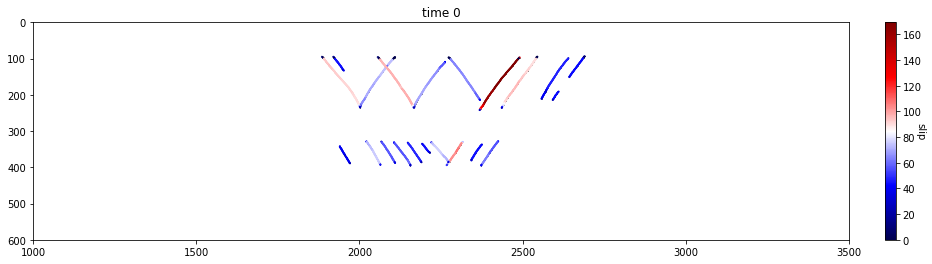

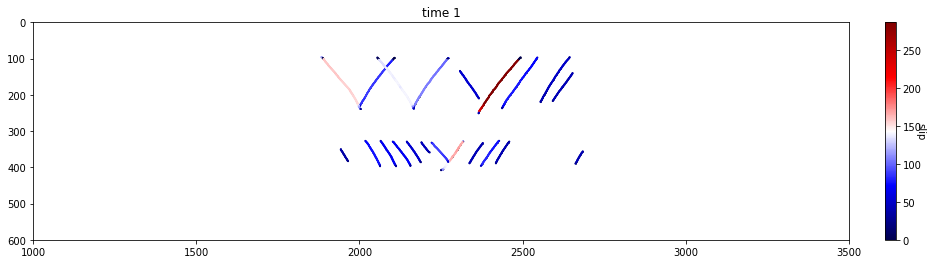

In [24]:
G_0 = Gs[0]
G_1 = Gs[1]

fig, ax = plt.subplots(figsize=(16,4))
plot_attribute(G_0, 'slip', ax)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_attribute(G_1, 'slip', ax)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()


First we just copy over slip to displacement:

In [25]:
def write_slip_to_displacement(G, dim):    
    if dim == 2:
        for node in G:
            G.nodes[node]['heave'] = G.nodes[node]['slip_x']
            G.nodes[node]['throw'] = G.nodes[node]['slip_z']
            G.nodes[node]['displacement'] = G.nodes[node]['slip']

    if dim == 3:
        for node in G:
            G.nodes[node]['heave']   = G.nodes[node]['slip_x']            
            G.nodes[node]['lateral'] = G.nodes[node]['slip_y']
            G.nodes[node]['throw']   = G.nodes[node]['slip_z']
            G.nodes[node]['displacement'] = G.nodes[node]['slip']
    return G

G_0 = write_slip_to_displacement(G_0, dim=2)
G_1 = write_slip_to_displacement(G_1, dim=2)

print(G_0.nodes[10])

{'pos': (2538, 104), 'component': 0, 'polarity': 0, 'edges': 2, 'fault': 0, 'dx': -5, 'dy': 6, 'slip_rate_x': 0.0005521000000000002, 'slip_rate_z': 0.0007752429, 'slip_rate': 0.0009517436440556932, 'slip_x': 52.341479632698956, 'slip_z': 73.49639641504157, 'slip': 90.2294340896427, 'heave': 52.341479632698956, 'throw': 73.49639641504157, 'displacement': 90.2294340896427}


Now we find the faults common to both time steps:

In [26]:
def get_fault_labels(G):
    labels=set()
    for node in G:
        labels.add(G.nodes[node]['fault'])
    return sorted(list(labels))       

def common_faults(G, H):
    C_G = get_fault_labels(G)
    C_H = get_fault_labels(H)
    return list(set(C_G) & set(C_H))

cf = common_faults(G_0, G_1)
print(cf)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Let's check:

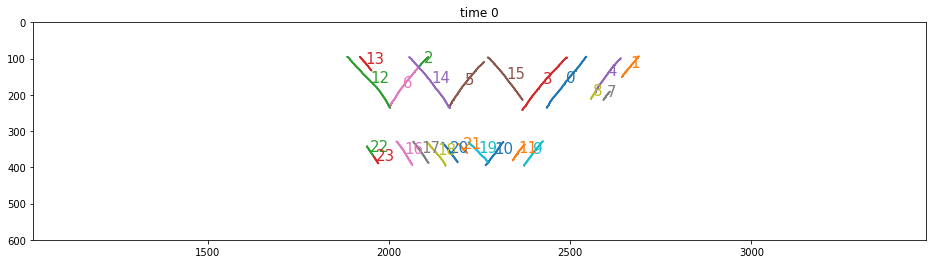

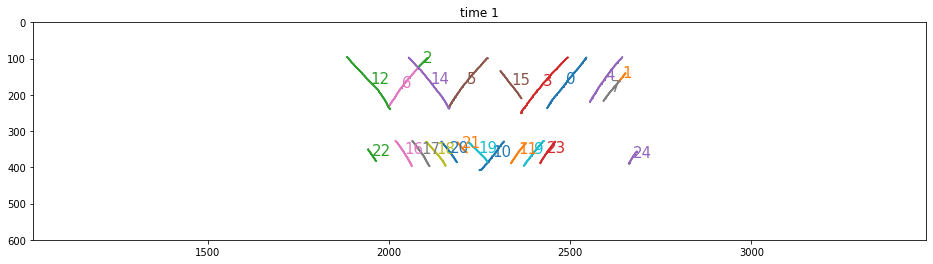

In [27]:
fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G_0, ax, label=True)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_faults(G_1, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Looks good!

Now we need two more functions: one to get a fault and one to get the displacement with coordinates of the fault.

In [28]:
def get_fault(G, n):
    nodes = [node for node in G if G.nodes[node]['fault']==n]
    return G.subgraph(nodes)

def get_displacement(G, dim):  
    if dim == 2:
        points = np.zeros((len(list(G)),6))    
        for n, node in enumerate(G):
            points[n,0] = node
            points[n,1] = G.nodes[node]['pos'][0]
            points[n,2] = G.nodes[node]['pos'][1]
            points[n,3] = G.nodes[node]['heave']
            points[n,4] = G.nodes[node]['throw']
            points[n,5] = G.nodes[node]['displacement']
    if dim == 3:
        points = np.zeros((len(list(G)),7))    
        for n, node in enumerate(G):
            points[n,0] = node
            points[n,1] = G.nodes[node]['pos'][0]
            points[n,2] = G.nodes[node]['pos'][1]
            points[n,3] = G.nodes[node]['heave']
            points[n,4] = G.nodes[node]['lateral']
            points[n,5] = G.nodes[node]['throw']
            points[n,6] = G.nodes[node]['displacement']
    return points

Now let's:

1.   Go through the common faults
2.   Get their displacement with coordinates
3.   Find the closest points
4.   Add the displacement from time 0 to time 1

In [29]:
for fault in cf:
    
    points_0 = get_displacement(get_fault(G_0, fault), dim=2)
    points_1 = get_displacement(get_fault(G_1, fault), dim=2)

    for n in range(points_1.shape[0]):    
        index = closest_node(points_1[n,1:3], points_0[:,1:3]) 
        
        points_1[n,3] += points_0[index][3]
        points_1[n,4] += points_0[index][4]
        points_1[n,5] += points_0[index][5]
    
    G_1 = assign_displacement(G_1, points_1, dim=2)

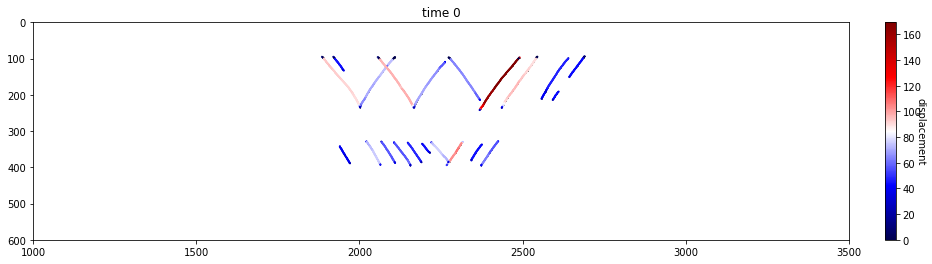

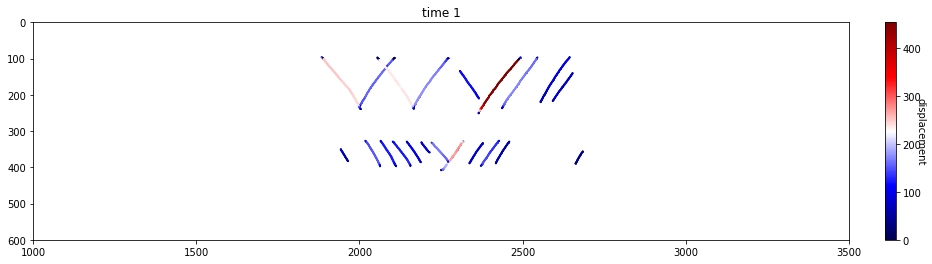

In [30]:
fig, ax = plt.subplots(figsize=(16,4))
plot_attribute(G_0, 'displacement', ax)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_attribute(G_1, 'displacement', ax)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Okay, they still look similar... but the colorbar stretches much further, so the displacement at time 1 really includes the slip from time 0!

Now let's do this for all time steps:

In [32]:
max_comp = 0

for time in range(len(Gs)-1):

  print(time)

  G_0 = Gs[time]
  G_1 = Gs[time+1]

  if time == 0:
    G_0 = write_slip_to_displacement(G_0, dim=2)  
    Gs[time] = G_0
  
  G_1 = write_slip_to_displacement(G_1, dim=2)

  cf = common_faults(G_0, G_1)

  for fault in cf:
    
    points_0 = get_displacement(get_fault(G_0, fault), dim=2)
    points_1 = get_displacement(get_fault(G_1, fault), dim=2)

    for n in range(points_1.shape[0]):    
        index = closest_node(points_1[n,1:3], points_0[:,1:3]) 
        
        points_1[n,3] += points_0[index][3]
        points_1[n,4] += points_0[index][4]
        points_1[n,5] += points_0[index][5]
    
    G_1 = assign_displacement(G_1, points_1, dim=2)

  Gs[time+1] = G_1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [34]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_attribute(Gs[time], 'displacement', ax)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=45, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=45, min=3), Out…